# Выбор региона для бурения нефтяных скважин

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Введение</a></span><ul class="toc-item"><li><span><a href="#Цели-и-задачи" data-toc-modified-id="Цели-и-задачи-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Цели и задачи</a></span></li><li><span><a href="#Структура-данных" data-toc-modified-id="Структура-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Структура данных</a></span></li></ul></li><li><span><a href="#Обзор-и-подготовка-данных" data-toc-modified-id="Обзор-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Итоги-исследования" data-toc-modified-id="Итоги-исследования-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоги исследования</a></span></li></ul></div>

## Введение

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новые скважины.

Нам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов.

### Цели и задачи

**Цель исследования:**

Выбрать регион для разработки скважин.

**Задачи:**

1. Провести обзор и подготовку данных;
2. Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль;
3. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия;
- При разведке региона исследуют 500 скважин, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
- Бюджет на разработку скважин в регионе — 10 млрд рублей;
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### Структура данных

Данные геологоразведки трёх регионов находятся в трёх файлах.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

- **`id`** — уникальный идентификатор скважины;
- **`f0`**, **`f1`**, **`f2`** — три признака точек;
- **`product`** — объём запасов в скважине (тыс. баррелей).

## Обзор и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
BOREHOLES = 500 # Скважин исследуют в регионе
BEST_BOREHOLES = 200 # Скважин выбирают для разработки с помощью ML
BUDGET = 10000 # Бюджет в млн. руб.
BARREL_PRICE = 0.45 # Доход с 1 тыс. баррелей в млн. руб.
RISK_BORDER = 0.025 # Граница допустимой вероятности убытков в долях

In [3]:
reg_1 = pd.read_csv('https://code.s3.yandex.net//datasets/geo_data_0.csv')
reg_2 = pd.read_csv('https://code.s3.yandex.net//datasets/geo_data_1.csv')
reg_3 = pd.read_csv('https://code.s3.yandex.net//datasets/geo_data_2.csv')

Выведем на экран основную информацию о данных:

In [4]:
# Создаем список и словарь регионов, чтобы итерировать по ним
reg_list = [reg_1, reg_2, reg_3]
reg_dict = {0: 'Регион 1', 1: 'Регион 2', 2: 'Регион 3'}

In [5]:
for i in range(len(reg_list)):
    print()
    print(reg_dict.get(i))
    print()
    reg_list[i].info()
    print()


Регион 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Регион 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Регион 3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 

Видим, что каждый из трех датафреймов состоит из 100 тысяч строк.

Пропусков в данных нет. Все столбцы, кроме **'id'**, принадлежат к числовому типу.

Выведем на экран первые строки таблиц:

In [6]:
for i in range(len(reg_list)):
    print()
    print(reg_dict.get(i))
    display(reg_list[i].head())
    print()


Регион 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647




Регион 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305




Регион 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Теперь выведем для каждого датафрейма основные статистические параметры:

In [7]:
for i in range(len(reg_list)):
    print()
    print(f'{reg_dict.get(i)}. Описание данных')
    display(reg_list[i].describe())
    print()


Регион 1. Описание данных


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347




Регион 2. Описание данных


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408




Регион 3. Описание данных


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Видим, что признаки не нуждаются в масштабировании. Теперь посмотрим на общие гистограммы:


Регион 1. Общая гистограмма


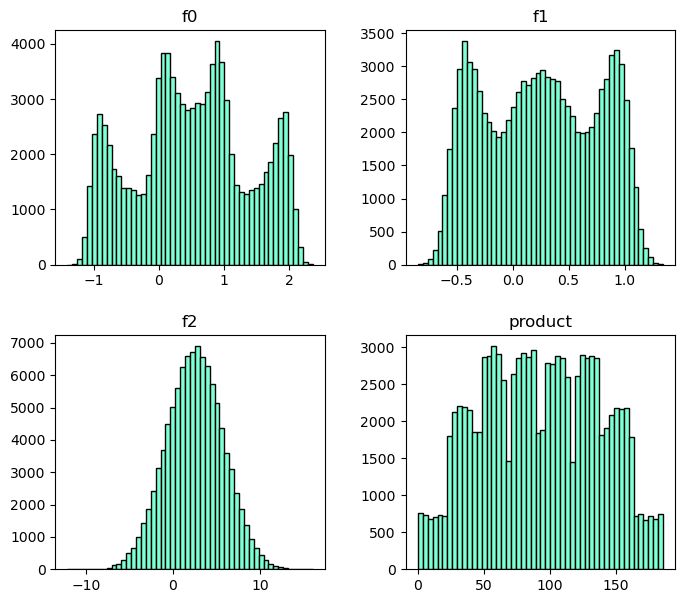


Регион 2. Общая гистограмма


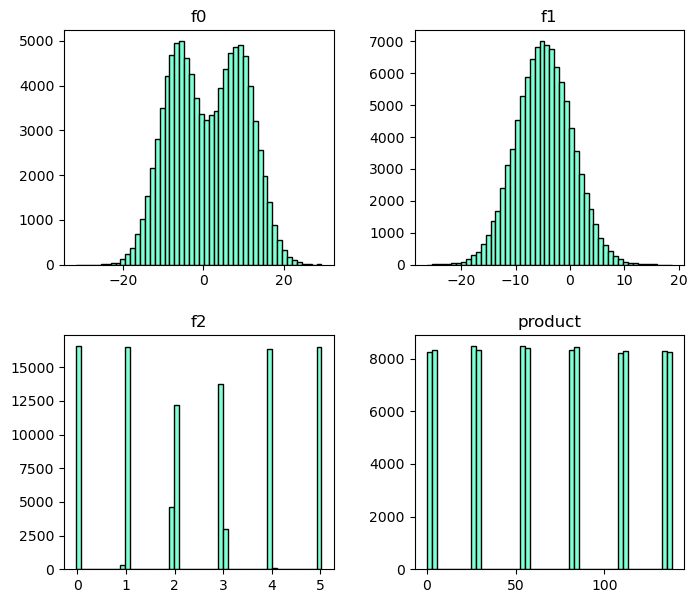


Регион 3. Общая гистограмма


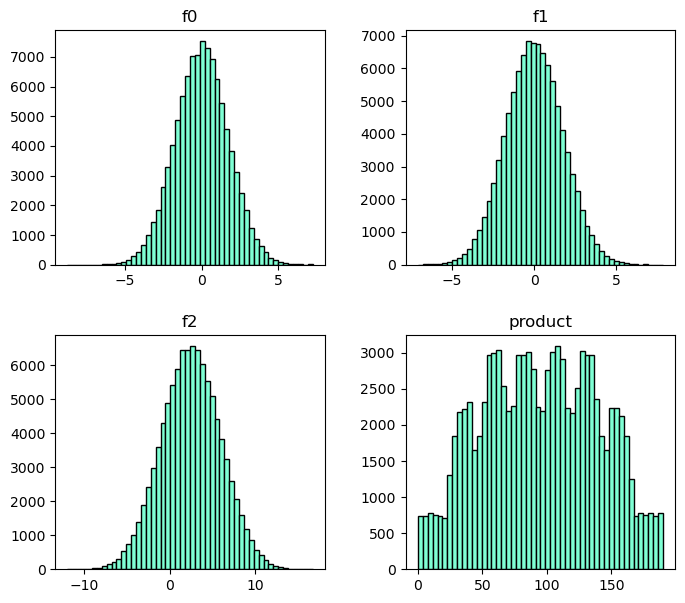

In [8]:
for i in range(len(reg_list)):
    print()
    print(f'{reg_dict.get(i)}. Общая гистограмма')
    reg_list[i].hist(figsize=(8,7), bins=50, grid=False, color='aquamarine', ec='black')
    plt.show()

Распределение значений целевого признака **'product'** и признака **'f2'** в **регионе 2** не выглядит нормальным. Кроме того, в столбце **'product'** присутствует больше количество нулей. Посмотрим внимательнее на его состав:

In [9]:
reg_2['product'].value_counts().to_frame()

,product
53.906522,8472
26.953261,8468
84.038886,8431
57.085625,8390
3.179103,8337
80.859783,8320
30.132364,8306
134.766305,8304
110.992147,8303
0.000000,8235


Выглядит так, будто 8235 скважин в **регионе 2** не принесли нефти вообще.

Теперь проверим данные на наличие дубликатов:

In [10]:
for i in range(len(reg_list)):
    print(f'Количество дубликатов по id в датафрейме "{reg_dict.get(i)}":', reg_list[i]['id'].duplicated().sum())

Количество дубликатов по id в датафрейме "Регион 1": 10
Количество дубликатов по id в датафрейме "Регион 2": 4
Количество дубликатов по id в датафрейме "Регион 3": 4


Посмотрим на строки с дублирующимися значениями **'id'**:

In [11]:
for i in range(len(reg_list)):
    print()
    print(reg_dict.get(i))
    duplicated_id = reg_list[i].query('id.duplicated(keep=False)').sort_values(by='id')
    display(duplicated_id)


Регион 1


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502



Регион 2


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305



Регион 3


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Видим, что строки-дубликаты по параметру **'id'** различны в остальных своих параметрах. Возможно, на одних и тех же скважинах использовали разную технологию, либо это ошибка при формировании датасетов.

Оставим эти дубликаты как есть и удалим из таблиц столбцы **'id'**, так как они содержат индивидуальные идентификаторы, бесполезные для обучения модели:

In [12]:
reg_1 = reg_1.drop('id', axis=1)
reg_2 = reg_2.drop('id', axis=1)
reg_3 = reg_3.drop('id', axis=1)

In [13]:
reg_list = [reg_1, reg_2, reg_3]

Теперь рассмотрим корреляции признаков.

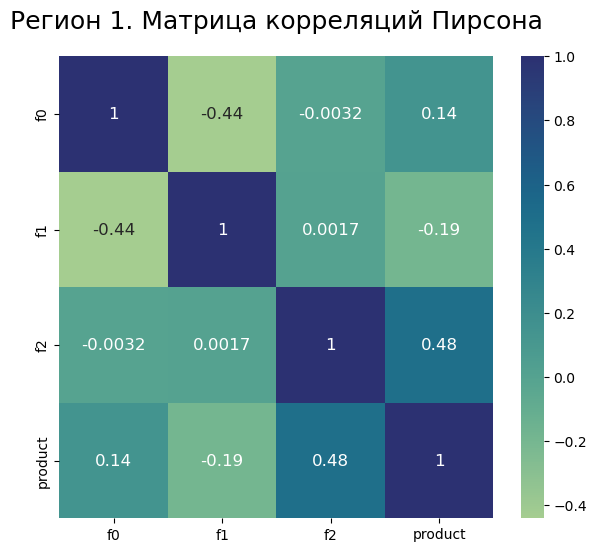

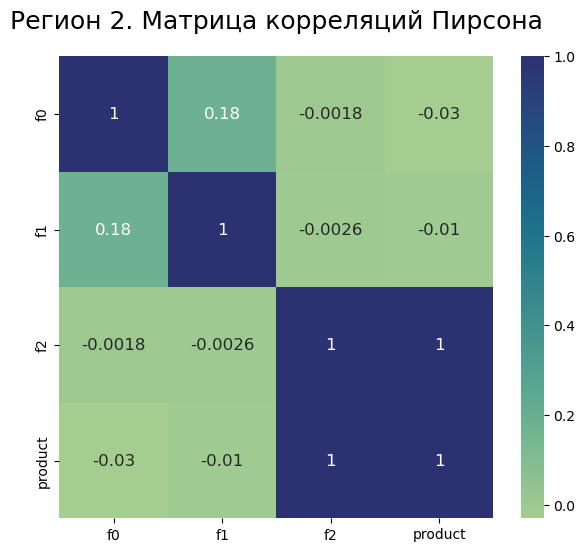

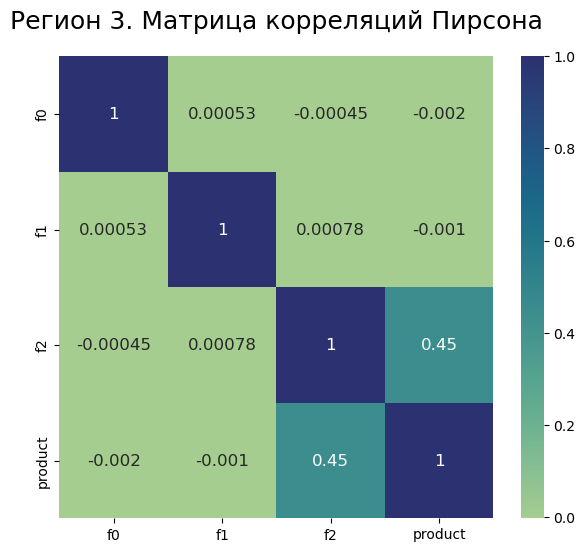

In [14]:
for i in range(len(reg_list)):
    plt.figure(figsize=(7,6))
    sns.heatmap(reg_list[i].corr(), annot=True, cmap='crest', annot_kws={'size':12})
    plt.title(f'{reg_dict.get(i)}. Матрица корреляций Пирсона', fontsize=18, pad=20)
    plt.show()

Мультиколлинеарности признаков не обнаружено. В **первом регионе** признак **'f0'** кореллирует с признаком **'f1'**, но корреляция ниже средней.

Для **первого** и **третьего регионов** корреляция признаков **'f2'** и **'product'** чуть ниже средней, а вот для **второго** — очень высокая: мы наблюдаем полную положительную линейную связь. Далее увидим, как это повлияет на результаты предсказаний модели.

**Выводы**:

Мы изучили данные и установили, что:

- каждый из трех датафрэймов состоит из 100 тысяч строк;
- все столбцы, кроме **'id'**, принадлежат к числовому типу;
- пропусков в данных нет;
- присутствуют дубликаты по **'id'**, которые различны в остальных своих параметрах; мы не стали с ними ничего делать;
- в **регионе 2** в столбце целевого признака **'product'** присутствует большое количество нулей; выглядит так, будто 8235 скважин в **регионе 2** не принесли нефти вообще.
- распределение признака **'f2'** и целевого признака **'product'** во втором регионе не нормальное;
- мультиколлинеарности признаков не обнаружено ни в одном из регионов; в **первом регионе** признак **'f0'** кореллирует с признаком **'f1'**, но корреляция ниже средней;
- во всех регионах признак **'f2'** коррелирует с **'product'**, для **первого** и **третьего** регионов корреляция чуть ниже средней, а вот для второго — очень высокая: мы наблюдаем полную положительную линейную связь.

Также мы подготовили данные для дальнейшей работы: удалили из таблиц столбцы **'id'**, так они содержат индивидуальные идентификаторы, бесполезные для обучения модели.

## Обучение и проверка модели

Создадим функцию, которая:

- разобьёт данные на обучающую и валидационную выборки в соотношении 75:25;
- стандартизирует признаки;
- обучит модель, которая сделает предсказания на валидационной выборке;
- посчитает и выведет на экран средний запас предсказанного сырья;
- подсчитает и выведет на экран метрики модели: *RMSE (квадратный корень из средней квадратичной ошибки), MAE (среднее абсолютное отклонение) и R2 (коэффициент детерминации)*;
- вернет предсказания и правильные ответы на валидационной выборке, чтобы мы могли их сохранить.

In [15]:
pd.options.mode.chained_assignment = None

In [16]:
def reg_predictor(reg, region):
    
    print(region)
    print('--')
    
    # Разбиваем данные на выборки
    features = reg.drop('product', axis=1)
    target = reg['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    print(f'Размеры обучающей выборки: признаки: {features_train.shape}, целевой признак: {target_train.shape}')
    print(f'Размеры валидационной выборки: признаки: {features_valid.shape}, целевой признак: {target_valid.shape}')
    print('--')
    
    # Обучаем модель и делаем предсказания
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    # Считаем средний запас предсказанного сырья 
    mean_product = predictions.mean()
    print('Cредний запас предсказанного сырья: {:.2f} тыс. баррелей'.format(mean_product))
    print('--')
    
    # Считаем метрики модели
    rmse = mean_squared_error(target_valid, predictions) ** 0.5
    print('RMSE модели: {:.2f} тыс. баррелей'.format(rmse))
    mae = mean_absolute_error(target_valid, predictions)
    print('MAE модели: {:.2f} тыс. баррелей'.format(mae))
    r2 = r2_score(target_valid, predictions)
    print('R2 модели: {:.4f}'.format(r2))
    
    return target_valid, pd.Series(predictions)

Вызовем функцию для каждого региона:

In [17]:
target_valid_1, predictions_1 = reg_predictor(reg_1, reg_dict.get(0))

Регион 1
--
Размеры обучающей выборки: признаки: (75000, 3), целевой признак: (75000,)
Размеры валидационной выборки: признаки: (25000, 3), целевой признак: (25000,)
--
Cредний запас предсказанного сырья: 92.59 тыс. баррелей
--
RMSE модели: 37.58 тыс. баррелей
MAE модели: 30.92 тыс. баррелей
R2 модели: 0.2799


In [18]:
target_valid_2, predictions_2 = reg_predictor(reg_2, reg_dict.get(1))

Регион 2
--
Размеры обучающей выборки: признаки: (75000, 3), целевой признак: (75000,)
Размеры валидационной выборки: признаки: (25000, 3), целевой признак: (25000,)
--
Cредний запас предсказанного сырья: 68.73 тыс. баррелей
--
RMSE модели: 0.89 тыс. баррелей
MAE модели: 0.72 тыс. баррелей
R2 модели: 0.9996


In [19]:
target_valid_3, predictions_3 = reg_predictor(reg_3, reg_dict.get(2))

Регион 3
--
Размеры обучающей выборки: признаки: (75000, 3), целевой признак: (75000,)
Размеры валидационной выборки: признаки: (25000, 3), целевой признак: (25000,)
--
Cредний запас предсказанного сырья: 94.97 тыс. баррелей
--
RMSE модели: 40.03 тыс. баррелей
MAE модели: 32.79 тыс. баррелей
R2 модели: 0.2052


**Выводы**:

Мы обучили и проверили модель для каждого региона.

Наибольший средний запас предсказанного сырья **в регионе 3: около 95 тыс. баррелей.**

Лучшее (наименьшее) значение метрик *RMSE* (0.89) и *MAE* (0.72), а также лучшее (наибольшее) значение метрики *R2* (0.9996) модель показала в **регионе 2** (скорее всего, это связано с очень высокой корреляцией признака *'f2'* и целевого признака, которую мы отметили ранее). Однако, несмотря на высокую точность предсказания модели, в этом регионе наименьший средний запас предсказанного сырья — 68.7 тыс. баррелей.

## Подготовка к расчёту прибыли

Рассчитаем достаточный запас сырья для безубыточной разработки новой скважины:

In [20]:
product_sufficient = round(BUDGET / (BEST_BOREHOLES * BARREL_PRICE), 2)
print(f'Достаточный запас сырья для безубыточной разработки новой скважины: {product_sufficient} тыс. баррелей')

Достаточный запас сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей


Сравним достаточный запас сырья со средним запасом сырья в каждом регионе:

In [21]:
reg_product_list = []

i = 1
for reg in reg_list:
    reg_product = round(reg['product'].mean(), 2)
    reg_product_list.append(reg_product)
    if reg_product < product_sufficient:
        print(f'Средний запас сырья в регионе {i} недостаточный: {reg_product} тыс. баррелей')
    else: 
        print(f'Средний запас сырья в регионе {i} достаточный: {reg_product} тыс. баррелей')
    i += 1

Средний запас сырья в регионе 1 недостаточный: 92.5 тыс. баррелей
Средний запас сырья в регионе 2 недостаточный: 68.83 тыс. баррелей
Средний запас сырья в регионе 3 недостаточный: 95.0 тыс. баррелей


То же самое видим на графике:

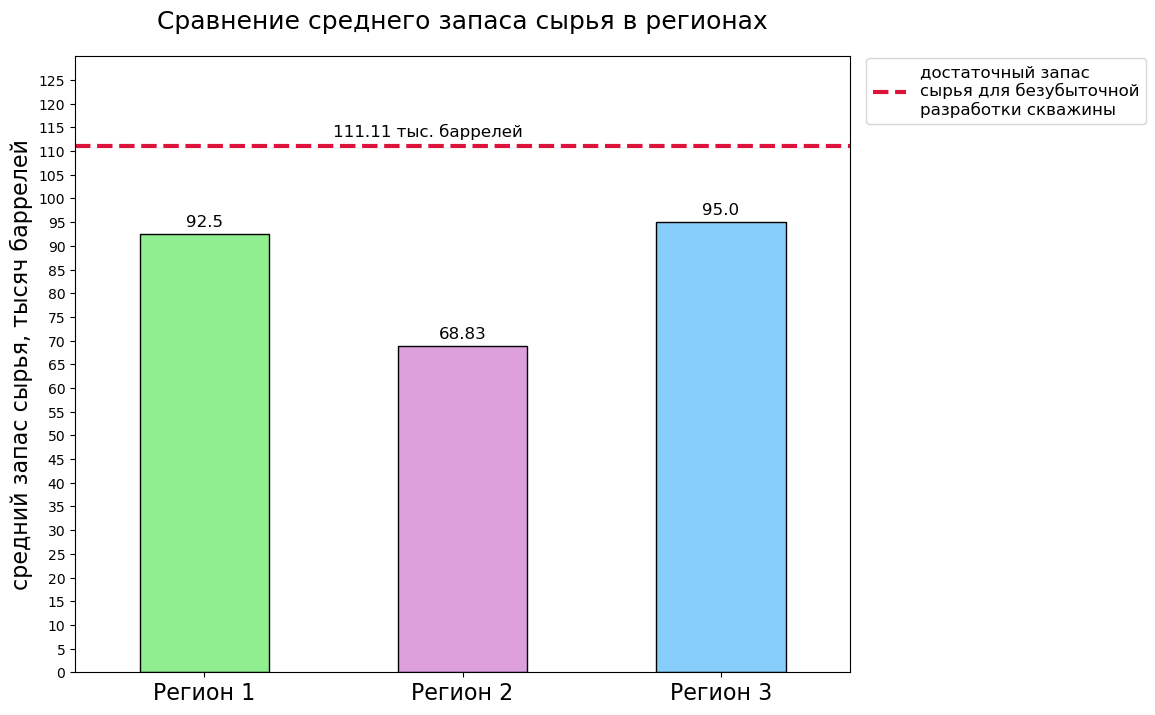

In [22]:
reg_product_table = pd.Series(reg_product_list, index=['Регион 1', 'Регион 2', 'Регион 3'])
colors=['lightgreen', 'plum', 'lightskyblue']

plt.figure(figsize=(10,8)) 
reg_product_table.plot(kind='bar', width=0.5, ec='black', color=colors)
plt.ylim(0,130)
plt.axhline(y=product_sufficient, linewidth=3, color='crimson', linestyle='--')
plt.text(0.5, 113, str(product_sufficient)+' тыс. баррелей', fontsize=12)
plt.title('Сравнение среднего запаса сырья в регионах', fontsize=18, pad=20)
for i in range(len(reg_product_table)):
    plt.annotate(str(reg_product_table[i]), xy=(i,reg_product_table[i]+1), ha='center', va='bottom', fontsize=12)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(ticks=range(0,130,5), fontsize=10)
plt.ylabel('средний запас сырья, тысяч баррелей', fontsize=16)
plt.legend(['достаточный запас\nсырья для безубыточной\nразработки скважины'],
           fontsize=12, loc=2, bbox_to_anchor=(1.01,1.01))
plt.show()

**Выводы**:

Мы рассчитали достаточный запас сырья для безубыточной разработки новой скважины. Он равен **111.11 тыс. баррелей**.

Затем мы сравнили достаточный запас сырья со средним запасом сырья в каждом регионе. Средний запас сырья во всех регионах оказался ниже минимально необходимого для безубыточной разработки, но этот факт сам по себе мало о чем говорит, поскольку из 100 тысяч месторождений в разработку пойдут 200 лучших из случайно выбранных 500.

Наибольший средний запас сырья **в регионе 3: 95 тыс. баррелей**.

## Расчёт прибыли и рисков 

Напишем функцию для расчета потенциальной прибыли:

In [23]:
def revenue(target, predictions):
    
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:BEST_BOREHOLES]
    revenue = BARREL_PRICE * selected.sum() - BUDGET
    
    return revenue

Теперь создадим функцию, которая:

- реализует технику Bootstrap с 1000 выборок и найдет распределение прибыли;
- рассчитает среднюю прибыль;
- найдет 95%-й доверительный интервал для прибыли;
- рассчитает вероятность убытков;
- вернет среднюю прибыль, вероятность убытков в процентах.

In [24]:
def reg_calculator(target, predictions, region):
    
    print(region)
    print('--')
    
    values = []
    state = np.random.RandomState(12345)
    
    # Применяем Bootstrap с 1000 выборок
    # Сбрасываем индексы у target, чтобы они совпали с индексами predictions
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(BOREHOLES, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        values.append(revenue(target_subsample, predictions_subsample))

    # Находим среднюю прибыль
    values = pd.Series(values)
    mean = round(values.mean(), 2)
    print(f'Средняя прибыль: {mean} млн. рублей')
    
    # Находим 95%-й доверительный интервал
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print('95% доверительный интервал: от {:.2f} до {:.2f} млн. рублей'.format(lower, upper))

    # Находим вероятность убытков и сравниваем с максимально допустимой
    risk = (values < 0).mean()
    if risk < RISK_BORDER:
        print('Вероятность убытков в пределах допустимого: {:.1%}'.format(risk))
    else:
        print('Вероятность убытков слишком велика: {:.1%}'.format(risk))
    
    return mean, risk * 100

Вызовем эту функцию для каждого региона:

In [25]:
mean_1, risk_1 = reg_calculator(target_valid_1, predictions_1, reg_dict.get(0))

Регион 1
--
Средняя прибыль: 425.94 млн. рублей
95% доверительный интервал: от -102.09 до 947.98 млн. рублей
Вероятность убытков слишком велика: 6.0%


In [26]:
mean_2, risk_2 = reg_calculator(target_valid_2, predictions_2, reg_dict.get(1))

Регион 2
--
Средняя прибыль: 515.22 млн. рублей
95% доверительный интервал: от 68.87 до 931.55 млн. рублей
Вероятность убытков в пределах допустимого: 1.0%


In [27]:
mean_3, risk_3 = reg_calculator(target_valid_3, predictions_3, reg_dict.get(2))

Регион 3
--
Средняя прибыль: 435.01 млн. рублей
95% доверительный интервал: от -128.88 до 969.71 млн. рублей
Вероятность убытков слишком велика: 6.4%


Для большей наглядности изобразим на графиках:

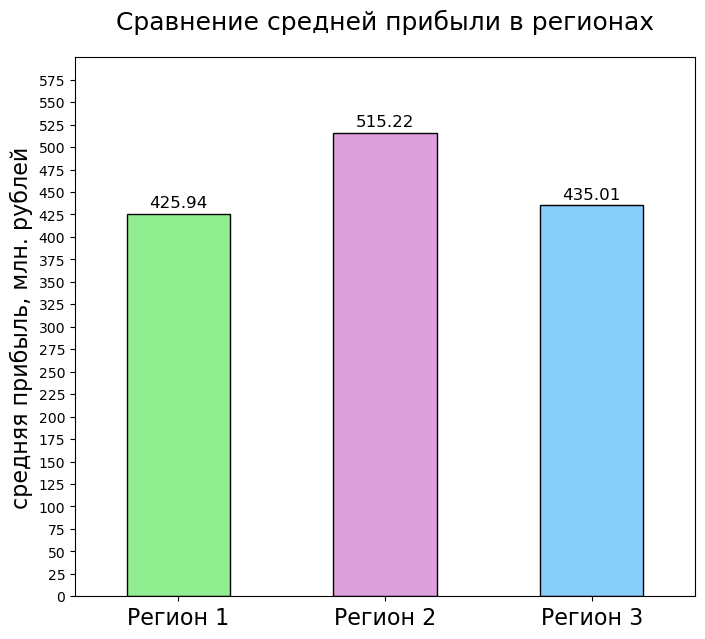

In [28]:
mean_table = pd.Series([mean_1, mean_2, mean_3], index=['Регион 1', 'Регион 2', 'Регион 3'])

plt.figure(figsize=(8,7)) 
mean_table.plot(kind='bar', width=0.5, ec='black', color=colors)
plt.ylim(0,600)
plt.title('Сравнение средней прибыли в регионах', fontsize=18, pad=20)
for i in range(len(mean_table)):
    plt.annotate(str(mean_table[i]), xy=(i,mean_table[i]+4), ha='center', va='bottom', fontsize=12)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(ticks=range(0,600,25), fontsize=10)
plt.ylabel('средняя прибыль, млн. рублей', fontsize=16)
plt.show()

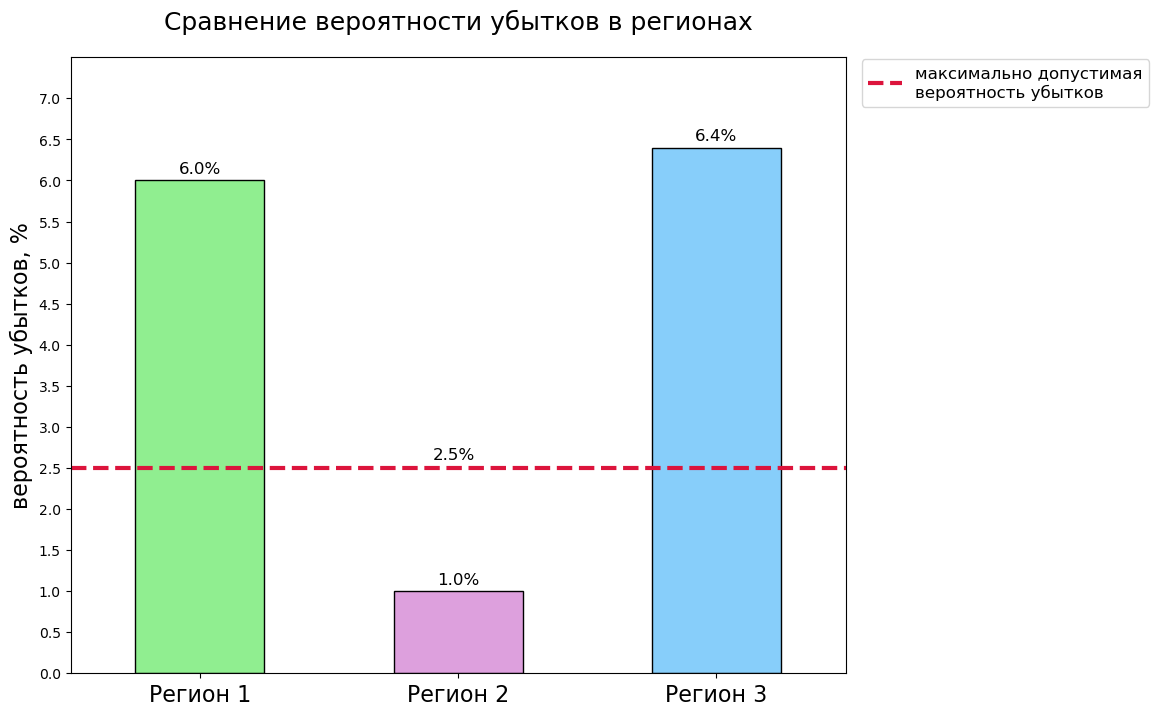

In [29]:
risk_table = pd.Series([risk_1, risk_2, risk_3], index=['Регион 1', 'Регион 2', 'Регион 3'])

plt.figure(figsize=(10,8)) 
risk_table.plot(kind='bar', width=0.5, ec='black', color=colors)
plt.ylim(0,7.5)
plt.axhline(y=RISK_BORDER*100, linewidth=3, color='crimson', linestyle='--')
plt.text(0.9, 2.6, str(RISK_BORDER*100)+'%', fontsize=12)
plt.title('Сравнение вероятности убытков в регионах', fontsize=18, pad=20)
for i in range(len(risk_table)):
    plt.annotate((str(risk_table[i])+'%'), xy=(i,risk_table[i]+0.05), ha='center', va='bottom', fontsize=12)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(ticks=np.arange(0.0,7.5,0.5), fontsize=10)
plt.ylabel('вероятность убытков, %', fontsize=16)
plt.legend(['максимально допустимая\nвероятность убытков'],
           fontsize=12, loc=2, bbox_to_anchor=(1.01,1.01))
plt.show()

**Выводы**:

Мы реализовали технику *Bootstrap* с 1000 выборок и нашли распределение прибыли, рассчитали среднюю прибыль, нашли 95%-й доверительный интервал прибыли и рассчитали вероятность убытков для каждого региона.

Самая высокая средняя прибыль у **региона 2: 515.22 млн. рублей**. Кроме того, **только у региона 2 в 95%-й доверительный интервал прибыли не входят отрицательные значения и вероятность убытков находится в пределах допустимого и равна 1%**.

**Таким образом для дальнейшей разработки нефтяных скважин рекомендуется выбрать регион 2, так как вероятность убытков мала и средняя прибыль выше, чем у остальных регионов**.

## Итоги исследования

**Целью нашего исследования было с помощью машинного обучения определить регион, в котором разработка нефтяных скважин принесёт компании наибольшую прибыль**.

**В первой части** исследования мы провели общий обзор данных и выяснили, что:

- каждый из трех датафрэймов состоит из 100 тысяч строк;
- все столбцы, кроме **'id'**, принадлежат к числовому типу;
- пропусков в данных нет;
- присутствуют дубликаты по **'id'**, которые различны в остальных своих параметрах; мы не стали с ними ничего делать;
- в **регионе 2** в столбце целевого признака **'product'** присутствует большое количество нулей; выглядит так, будто 8235 скважин в **регионе 2** не принесли нефти вообще.
- распределение признака **'f2'** и целевого признака **'product'** во втором регионе не нормальное;
- мультиколлинеарности признаков не обнаружено ни в одном из регионов; в **первом регионе** признак **'f0'** кореллирует с признаком **'f1'**, но корреляция ниже средней;
- во всех регионах признак **'f2'** коррелирует с **'product'**, для **первого** и **третьего** регионов корреляция чуть ниже средней, а вот для второго — очень высокая: мы наблюдаем полную положительную линейную связь.

Также мы подготовили данные для дальнейшей работы: удалили из таблиц столбцы **'id'**, так они содержат индивидуальные идентификаторы, бесполезные для обучения модели.

**Во второй части** мы обучили и проверили модель для каждого региона.

Наибольший средний запас предсказанного сырья получили в регионе 3: около 95 тыс. баррелей.

Лучшее (наименьшее) значение метрик *RMSE* (0.89) и *MAE* (0.72), а также лучшее (наибольшее) значение метрики *R2* (0.9996) модель показала в регионе 2 (скорее всего, это связано с очень высокой корреляцией признака *'f2'* и целевого признака, которую мы отметили ранее). Однако, несмотря на высокую точность предсказания модели, в этом регионе получили наименьший средний запас предсказанного сырья — 68.7 тыс. баррелей.

**В третьей части** мы провели подготовка к расчёту прибыли.

Рассчитали достаточный запас сырья для безубыточной разработки новой скважины. Он равен **111.11 тыс. баррелей**.

Затем мы сравнили достаточный запас сырья со средним запасом сырья в каждом регионе. Средний запас сырья во всех регионах оказался ниже минимально необходимого для безубыточной разработки, но этот факт сам по себе мало о чем говорит, поскольку из 100 тысяч месторождений в разработку пойдут 200 лучших из случайно выбранных 500.

Наибольший средний запас сырья также получили в регионе 3: 95 тыс. баррелей.

**В заключительной части** исследования мы реализовали технику *Bootstrap* с 1000 выборок и нашли распределение прибыли, рассчитали среднюю прибыль, нашли 95%-й доверительный интервал прибыли и рассчитали вероятность убытков для каждого региона.

**Мы пришли к выводу, что для дальнейшей разработки нефтяных скважин рекомендуется выбрать регион 2, так как только у данного региона вероятность убытков находится в пределах допустимого (1%) и средняя прибыль выше, чем у остальных регионов (515.22 млн. рублей)**.